In [13]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from graph_nets import blocks
from graph_nets import graphs
from graph_nets import modules
from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.demos.models import EncodeProcessDecode as EPD

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import sonnet as snt
import tensorflow as tf
import h5py
from progressbar import progressbar
import matplotlib.pyplot as plt
%matplotlib inline

Useful reference on using Sonnet:  
https://github.com/deepmind/sonnet/blob/v2/examples/mlp_on_mnist.ipynb  
DeepMind graph nn example on physics system:  
https://colab.research.google.com/github/deepmind/graph_nets/blob/master/graph_nets/demos/physics.ipynb#scrollTo=toCQhJIM93en  
graph_nets InteractionNetwork class:  
https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-modulesinteractionnetwork

#### Let's grab a few graphs

In [15]:
runname = "secondring_t1.0v1.0l10"
inputfname = "nn_inputs/"+runname+".hdf5"
h5in = h5py.File(inputfname,'r')
N_NODE_FEAT = 3
N_EDGE_FEAT = 6
N_NODE = h5in.attrs['n_nodes']
N_EDGE = h5in.attrs['n_edges']
NTG = h5in.attrs['nTG']
h5in.close()

In [14]:
def snap2graph(h5file,day,tg,placeholder=False):
    snapstr = 'day'+str(day)+'tg'+str(tg)
    glbls = h5file['glbl_features/'+snapstr][0] # Seems glbls have extra dimension
    nodes = h5file['node_features/'+snapstr]
    edges = h5file['edge_features/'+snapstr]
    senders = h5in['senders']
    receivers = h5in['receivers']

    graphdat_dict = {
        "globals": glbls[:],
        "nodes": nodes[:],
        "edges": edges[:],
        "senders": senders[:],
        "receivers": receivers[:]
    }

#     np_graphs_tuple = utils_np.data_dicts_to_graphs_tuple([graphdat_dict])
    if not placeholder:
        graphs_tuple = utils_np.data_dicts_to_graphs_tuple([graphdat_dict])
    else:
        graphs_tuple = utils_tf.placeholders_from_data_dicts([graphdat_dict])
     
    return graphs_tuple

In [66]:
tf.reset_default_graph()

h5in = h5py.File(inputfname,'r')
# edge_model_fn: a callable to perform per-edge computations, etc.
interaction_net = modules.InteractionNetwork(
    edge_model_fn=lambda: snt.Linear(output_size=N_EDGE_FEAT),
    node_model_fn=lambda: snt.Linear(output_size=N_NODE_FEAT))

input_graph = snap2graph(h5in,day=0,tg=0,placeholder=True)
output_graph = interaction_net(input_graph)
lbl_graph = snap2graph(h5in,day=0,tg=0,placeholder=True)

print("Output edges size: {}".format(output_graph.edges.shape[-1]))  # Equal to OUTPUT_EDGE_SIZE
print("Output nodes size: {}".format(output_graph.nodes.shape[-1]))  # Equal to OUTPUT_NODE_SIZE

loss = tf.losses.mean_squared_error(labels=lbl_graph.nodes, 
                                    predictions=output_graph.nodes)\
      +tf.losses.mean_squared_error(labels=lbl_graph.edges,
                                    predictions=output_graph.edges)
opt = tf.train.AdamOptimizer(learning_rate=1e-2)
loss_op = opt.minimize(loss)
h5in.close()

Output edges size: 6
Output nodes size: 3


#### We should include some standardization of the data

In [69]:
losses = []
sel_nodes_out, sel_nodes_input = [], []

with h5py.File(inputfname,'r') as h5in:
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in progressbar(range(10000)):
            tg = i%NTG
            day = (i//NTG)%7
            lbltg = (i+1)%NTG
            lblday = (day+((tg+1)//NTG))%7
#             day,lblday = 0, 0
            graph = snap2graph(h5in,day=day,tg=tg)
            lbl = snap2graph(h5in,day=lblday,tg=lbltg)
            train_dict = sess.run({
                "loss": loss,
                "loss_op": loss_op,
                "outputs": output_graph,
            }, feed_dict={
                input_graph: graph,
                lbl_graph: lbl
            })
            if (i)%100==0:
#                 print(day,tg,train_dict['loss'])
#                 sel_nodes_out.append([train_dict['outputs'].nodes[:3]])
                losses.append(train_dict['loss'])

        # Test

100% (10000 of 10000) |##################| Elapsed Time: 0:01:02 Time:  0:01:02


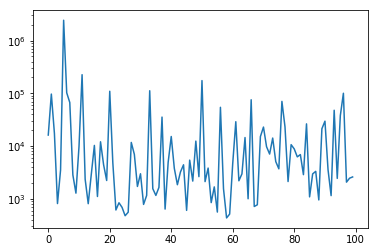

In [70]:
plt.semilogy(losses)

In [78]:
graph.edges[:10]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.        , 13.28155481,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.        , 13.28155481,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 3.        ,  2.51795393,  0.99395066,  2.        , 13.7940545 ,
        10.98831362],
       [ 2.        , 13.7940545 , 10.98831362,  2.        ,  3.18740248,
         0.37070581]])

In [79]:
lbl.edges[:10]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [1.        , 1.65478294, 0.        , 1.        , 1.31976201,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 1.        , 3.04009477,
        0.        ],
       [1.        , 3.04009477, 0.        , 0.        , 0.        ,
        0.        ]])

In [80]:
outputs = train_dict['outputs']
outputs.edges[:10]

array([[ 7.73947161e-01, -3.36415911e+00,  1.48535686e+00,
         5.73336252e+00, -1.90970898e+00, -1.10351579e+00],
       [ 1.19898224e+00, -2.72015518e+00,  6.34097308e-01,
         5.81738305e+00, -1.53049818e+00, -1.50227273e-01],
       [-2.89491304e-02, -4.90492218e+00,  7.65534154e-01,
         4.94618554e+00,  3.35299052e-01,  2.01137018e+00],
       [ 3.38587809e-01, -3.96288055e+00,  1.90793688e+00,
         5.86862566e+00, -2.31722563e+00, -1.91685643e+00],
       [ 1.56915493e+00, -3.33991497e+00,  6.43387510e+00,
         2.86760779e+00, -1.25641176e+00, -2.08417207e+00],
       [ 3.87079893e+01,  1.78189104e+01,  7.59381866e+01,
        -5.00992734e+01,  2.02435407e+01,  8.27295892e+00],
       [ 1.53648649e+01,  4.82926819e+00,  2.88062763e+01,
        -1.50036533e+01,  6.40417292e+00,  2.80448669e+00],
       [-2.89491304e-02, -4.90492218e+00,  7.65534154e-01,
         4.94618554e+00,  3.35299052e-01,  2.01137018e+00],
       [ 9.21311286e-02, -2.32393080e+00,  9.495

In [ ]:
a = np_graphs_tuple.replace(nodes=np_graphs_tuple.nodes[:10],
                            edges=np_graphs_tuple.edges[:10],
                            globals=np_graphs_tuple.globals[:10])

In [ ]:
outputs